# Extract feature vectors & Implement geometry-aware clipping, 3 methods

In [25]:
import numpy as np
import torch
import os, sys

project_root = os.path.abspath("..")
src_root = os.path.join(project_root, "src")

sys.path = [p for p in sys.path if p not in (project_root, src_root)]

sys.path.insert(0, project_root)
sys.path.insert(1, src_root)


if "src" in sys.modules:
    del sys.modules["src"]

import src

In [ ]:
import torch
import importlib

from src.features import FeatureStats, standardize, clip_quantile_box
import src.clip
import src.train

importlib.reload(src.clip)
importlib.reload(src.train)

from src.clip import (
    l2_group_clip,
    meb_clip,
    estimate_l2_radius,
    estimate_meb_params,
)
from src.train import train_classifier

In [3]:
from src.utils import set_seed, get_device
from src.data import load_har, make_train_val_test, make_dataloaders
from src.models import LRBaseline, SmallCNN
from src.train import train_classifier, evaluate_classifier

In [39]:
from src.data import load_har, make_train_val_test
import numpy as np

# Load raw HAR
X_train, y_train, X_test, y_test = load_har("../data")

# Make train/val/test splits (same seed)
(X_tr, y_tr), (X_val, y_val), (X_te, y_te) = make_train_val_test(
    X_train, y_train, X_test, y_test, val_ratio=0.2, seed=42
)

# Now build one continuous numpy array
X_all = np.concatenate([X_tr, X_val, X_te], axis=0).astype(np.float32)
y_all = np.concatenate([y_tr, y_val, y_te], axis=0).astype(np.int64)

print("X_all dtype:", X_all.dtype, "shape:", X_all.shape)
print("y_all dtype:", y_all.dtype, "shape:", y_all.shape)


dataset_dir: ../data/UCI_HAR_Dataset
X_all dtype: float32 shape: (10299, 561)
y_all dtype: int64 shape: (10299,)


In [ ]:
from src.utils import set_seed, get_device
from src.data import load_har, make_train_val_test, make_dataloaders

set_seed(42)
device = get_device()
print("Device:", device)

# Use the same data_root you used in run_cnn_baseline
data_root = "../data"  

# 1) Load original HAR split
X_train, y_train, X_test, y_test = load_har(data_root)

# 2) Make train / val / test
(X_tr, y_tr), (X_val, y_val), (X_te, y_te) = make_train_val_test(
    X_train, y_train, X_test, y_test, val_ratio=0.1, seed=42
)

# 3) Wrap into DataLoaders
train_loader, val_loader, test_loader = make_dataloaders(
    X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size=128
)

# 4) Inspect one batch to infer model shape
sample_X, _ = next(iter(train_loader))
print("Sample batch shape:", sample_X.shape)
in_channels = sample_X.shape[1]
num_classes = int(y_train.max() + 1)


Device: cpu
dataset_dir: ../data/UCI_HAR_Dataset
Sample batch shape: torch.Size([128, 1, 561])


In [5]:
stats = FeatureStats.load("feature_stats.npz")
stats

FeatureStats(mean=array([ 0.27448845, -0.01769541, -0.10914065, -0.60543936, -0.5109371 ,
       -0.60475415, -0.6305118 , -0.5269078 , -0.60614985, -0.46860316,
       -0.30604413, -0.55712056,  0.52355134,  0.3873843 ,  0.5943735 ,
       -0.54756886, -0.82004917, -0.90188277, -0.8457853 , -0.6843449 ,
       -0.64376885, -0.6310681 , -0.10299256, -0.13793729, -0.16394547,
       -0.11659874,  0.10276194, -0.03778547,  0.13047704, -0.02622928,
        0.02632182,  0.15996544, -0.01957489,  0.00941957,  0.03329054,
        0.03658654, -0.07864016, -0.1251307 , -0.19380221,  0.10500511,
        0.66412276,  0.01100602,  0.09392018, -0.964521  , -0.9536846 ,
       -0.9369282 , -0.96533585, -0.9546851 , -0.93827087,  0.60416526,
       -0.00328247,  0.09895921,  0.6785061 ,  0.023248  ,  0.08061405,
       -0.07833488,  0.43671033, -0.7303793 , -0.74470645, -0.9675648 ,
       -0.9580393 , -0.9430013 , -0.66750884, -0.8691355 , -0.68471617,
       -0.515771  ,  0.5531767 , -0.58990693, 

In [6]:
# ℓ2 radius in standardized space
R_l2 = estimate_l2_radius(train_loader, stats, quantile=0.99)
print("Estimated ℓ2 radius (0.99-quantile):", R_l2)

# MEB center + radius in standardized space
center_meb, R_meb = estimate_meb_params(train_loader, stats, quantile=0.99)
print("Estimated MEB radius (0.99-quantile):", R_meb)

Estimated ℓ2 radius (0.99-quantile): 54.800907135009766
Estimated MEB radius (0.99-quantile): 54.8348388671875


In [ ]:
def preprocess_baseline_batch(X: torch.Tensor) -> torch.Tensor:
    """
    Baseline: only standardization, no geometry-aware clipping.
    """
    return standardize(X, stats)


def preprocess_qbox_batch(X: torch.Tensor) -> torch.Tensor:
    """
    Method 1: quantile-box clipping in raw space, then standardize.
    """
    X_clip = clip_quantile_box(X, stats) 
    X_std = standardize(X_clip, stats) 
    return X_std


def preprocess_l2_batch(X: torch.Tensor) -> torch.Tensor:
    """
    Method 2: ℓ2 group clipping in standardized space.
    raw → standardize → ℓ2 clip
    """
    X_std = standardize(X, stats)
    X_l2 = l2_group_clip(X_std, max_norm=R_l2, group_axes=(-1,))
    return X_l2


def preprocess_meb_batch(X: torch.Tensor) -> torch.Tensor:
    """
    Method 3: MEB clipping in standardized space.
    raw → standardize → MEB clip
    """
    X_std = standardize(X, stats)
    X_meb = meb_clip(X_std, center=center_meb, radius=R_meb, group_axes=(-1,))
    return X_meb

In [8]:
from src.models import SmallCNN

def make_model():
    return SmallCNN(in_channels=in_channels, num_classes=num_classes)

In [9]:
model_qbox = make_model()
history_qbox = train_classifier(
    model_qbox, train_loader, val_loader, device,
    epochs=20, lr=1e-3,
    preprocess_fn=preprocess_qbox_batch,
)

Epoch 01: train_loss=1.3188, train_acc=0.3728, val_loss=1.0547, val_acc=0.4340
Epoch 02: train_loss=1.0015, train_acc=0.5049, val_loss=0.9950, val_acc=0.5211
Epoch 03: train_loss=0.9437, train_acc=0.5543, val_loss=0.9265, val_acc=0.5401
Epoch 04: train_loss=0.8956, train_acc=0.5678, val_loss=0.8546, val_acc=0.5769
Epoch 05: train_loss=0.8418, train_acc=0.5914, val_loss=0.8185, val_acc=0.5959
Epoch 06: train_loss=0.8142, train_acc=0.5986, val_loss=0.7803, val_acc=0.6068
Epoch 07: train_loss=0.7757, train_acc=0.6237, val_loss=0.7581, val_acc=0.6000
Epoch 08: train_loss=0.7464, train_acc=0.6317, val_loss=0.7402, val_acc=0.6218
Epoch 09: train_loss=0.7318, train_acc=0.6358, val_loss=0.7078, val_acc=0.6381
Epoch 10: train_loss=0.7030, train_acc=0.6538, val_loss=0.7444, val_acc=0.6082
Epoch 11: train_loss=0.6871, train_acc=0.6588, val_loss=0.6601, val_acc=0.6490
Epoch 12: train_loss=0.6624, train_acc=0.6736, val_loss=0.6497, val_acc=0.6789
Epoch 13: train_loss=0.6570, train_acc=0.6781, val_l

In [10]:
model_l2 = make_model()

history_l2 = train_classifier(
    model=model_l2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=20,
    lr=1e-3,
    preprocess_fn=preprocess_l2_batch,
)

Epoch 01: train_loss=1.2940, train_acc=0.3724, val_loss=1.0294, val_acc=0.4789
Epoch 02: train_loss=1.0356, train_acc=0.4869, val_loss=0.9965, val_acc=0.5347
Epoch 03: train_loss=1.0074, train_acc=0.5181, val_loss=1.0231, val_acc=0.4816
Epoch 04: train_loss=0.9877, train_acc=0.5291, val_loss=0.9558, val_acc=0.5388
Epoch 05: train_loss=0.9455, train_acc=0.5569, val_loss=0.9474, val_acc=0.5442
Epoch 06: train_loss=0.9021, train_acc=0.5947, val_loss=0.8531, val_acc=0.6068
Epoch 07: train_loss=0.8451, train_acc=0.6145, val_loss=0.7978, val_acc=0.6272
Epoch 08: train_loss=0.7950, train_acc=0.6275, val_loss=0.7912, val_acc=0.6204
Epoch 09: train_loss=0.7503, train_acc=0.6446, val_loss=0.7487, val_acc=0.6245
Epoch 10: train_loss=0.7295, train_acc=0.6511, val_loss=0.7317, val_acc=0.6218
Epoch 11: train_loss=0.7202, train_acc=0.6449, val_loss=0.7072, val_acc=0.6531
Epoch 12: train_loss=0.7057, train_acc=0.6556, val_loss=0.7051, val_acc=0.6503
Epoch 13: train_loss=0.6938, train_acc=0.6600, val_l

In [11]:
model_meb = make_model()

history_meb = train_classifier(
    model=model_meb,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=20,
    lr=1e-3,
    preprocess_fn=preprocess_meb_batch,
)

Epoch 01: train_loss=1.3113, train_acc=0.3701, val_loss=1.0867, val_acc=0.3728
Epoch 02: train_loss=1.0360, train_acc=0.4614, val_loss=1.0045, val_acc=0.5293
Epoch 03: train_loss=1.0053, train_acc=0.5194, val_loss=0.9763, val_acc=0.5388
Epoch 04: train_loss=0.9678, train_acc=0.5431, val_loss=0.9402, val_acc=0.5429
Epoch 05: train_loss=0.9371, train_acc=0.5776, val_loss=0.9173, val_acc=0.5782
Epoch 06: train_loss=0.9018, train_acc=0.5954, val_loss=0.8576, val_acc=0.6122
Epoch 07: train_loss=0.8507, train_acc=0.6211, val_loss=0.8152, val_acc=0.6150
Epoch 08: train_loss=0.7910, train_acc=0.6435, val_loss=0.7784, val_acc=0.6245
Epoch 09: train_loss=0.7560, train_acc=0.6536, val_loss=0.7568, val_acc=0.6422
Epoch 10: train_loss=0.7252, train_acc=0.6609, val_loss=0.7230, val_acc=0.6327
Epoch 11: train_loss=0.7024, train_acc=0.6671, val_loss=0.6868, val_acc=0.6571
Epoch 12: train_loss=0.6845, train_acc=0.6722, val_loss=0.6686, val_acc=0.6531
Epoch 13: train_loss=0.6711, train_acc=0.6746, val_l

In [12]:
from src.utils import set_seed, get_device
from src.data import load_har, make_train_val_test, make_dataloaders
from src.train import train_classifier, evaluate_classifier
from src.models import SmallCNN   # same model used in run_cnn_baseline

set_seed(42)
device = get_device()

# load dataset
data_root = "../data"
X_train, y_train, X_test, y_test = load_har(data_root)

# split
(X_tr, y_tr), (X_val, y_val), (X_te, y_te) = make_train_val_test(
    X_train, y_train, X_test, y_test, val_ratio=0.1, seed=42
)

train_loader, val_loader, test_loader = make_dataloaders(
    X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size=128
)

# create baseline model
sample_X, _ = next(iter(train_loader))
in_channels = sample_X.shape[1]
num_classes = int(y_train.max() + 1)

model_baseline = SmallCNN(in_channels=in_channels, num_classes=num_classes)

history_baseline = train_classifier(
    model_baseline, train_loader, val_loader, device,
    epochs=20, lr=1e-3, preprocess_fn=None   # baseline = no preprocessing
)


dataset_dir: ../data/UCI_HAR_Dataset
Epoch 01: train_loss=1.4712, train_acc=0.3038, val_loss=1.0958, val_acc=0.3932
Epoch 02: train_loss=1.0835, train_acc=0.4064, val_loss=1.0617, val_acc=0.4014
Epoch 03: train_loss=1.0661, train_acc=0.4138, val_loss=1.0559, val_acc=0.3918
Epoch 04: train_loss=1.0681, train_acc=0.4076, val_loss=1.0535, val_acc=0.3932
Epoch 05: train_loss=1.0543, train_acc=0.4333, val_loss=1.0686, val_acc=0.3728
Epoch 06: train_loss=1.0470, train_acc=0.4381, val_loss=1.0386, val_acc=0.4653
Epoch 07: train_loss=1.0334, train_acc=0.4576, val_loss=1.0336, val_acc=0.4735
Epoch 08: train_loss=1.0084, train_acc=0.5040, val_loss=0.9885, val_acc=0.4952
Epoch 09: train_loss=0.9778, train_acc=0.5330, val_loss=0.9437, val_acc=0.5673
Epoch 10: train_loss=0.9177, train_acc=0.5782, val_loss=0.9105, val_acc=0.5034
Epoch 11: train_loss=0.8645, train_acc=0.6050, val_loss=0.8234, val_acc=0.6259
Epoch 12: train_loss=0.7926, train_acc=0.6417, val_loss=0.7916, val_acc=0.5741
Epoch 13: train

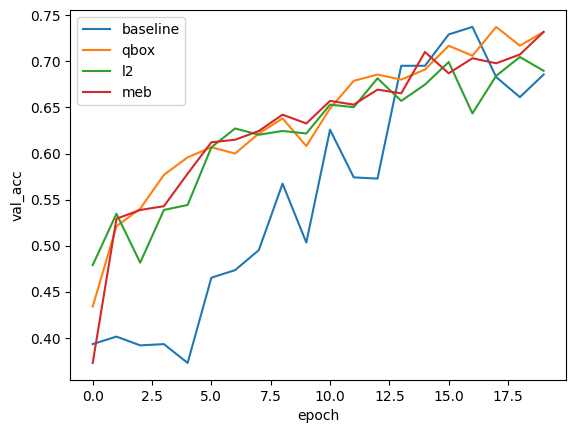

In [13]:
import matplotlib.pyplot as plt

def plot_history(hist, label):
    plt.plot(hist["val_acc"], label=label)

plt.figure()
plot_history(history_baseline, "baseline")
plot_history(history_qbox, "qbox")
plot_history(history_l2, "l2")
plot_history(history_meb, "meb")
plt.xlabel("epoch")
plt.ylabel("val_acc")
plt.legend()
plt.show()

# Implement Laplace LDP and generate first utility curves

Device: cpu
Example batch shape: torch.Size([128, 1, 561])

=== QBOX + Laplace LDP, eps=0.2 ===
Epoch 01: train_loss=1.7981, train_acc=0.1856, val_loss=1.7874, val_acc=0.1388
Epoch 02: train_loss=1.7686, train_acc=0.2027, val_loss=1.7535, val_acc=0.2041
Epoch 03: train_loss=1.7486, train_acc=0.2117, val_loss=1.7319, val_acc=0.2340
Epoch 04: train_loss=1.7378, train_acc=0.2154, val_loss=1.7318, val_acc=0.2122
Epoch 05: train_loss=1.7297, train_acc=0.2296, val_loss=1.7218, val_acc=0.2150
Epoch 06: train_loss=1.7265, train_acc=0.2231, val_loss=1.7510, val_acc=0.1973
Epoch 07: train_loss=1.7311, train_acc=0.2220, val_loss=1.7561, val_acc=0.2082
Epoch 08: train_loss=1.7248, train_acc=0.2299, val_loss=1.7142, val_acc=0.2340
Epoch 09: train_loss=1.7291, train_acc=0.2181, val_loss=1.7338, val_acc=0.2177
Epoch 10: train_loss=nan, train_acc=0.1744, val_loss=nan, val_acc=0.1796

=== QBOX + Laplace LDP, eps=0.5 ===
Epoch 01: train_loss=1.7418, train_acc=0.2170, val_loss=1.6689, val_acc=0.2626
Epoc

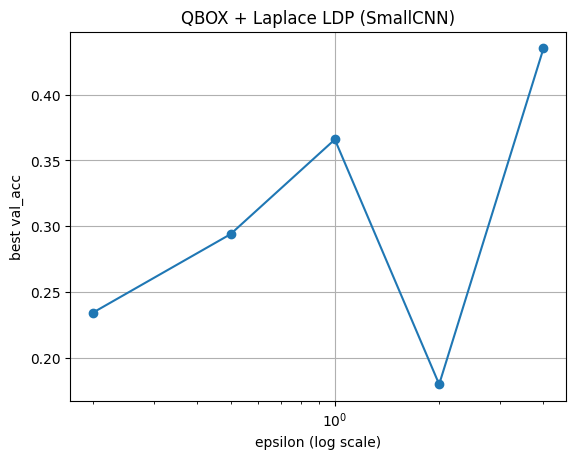

In [ ]:
import torch
import matplotlib.pyplot as plt

from src.utils import get_device
from src.features import FeatureStats
from src.ldp import apply_laplace_ldp_qbox
from src.models import SmallCNN
from src.train import train_classifier

device = get_device()
print("Device:", device)

# reuse the same stats as in Step 3
stats = FeatureStats.load("feature_stats.npz")

# -------- 1. LDP-aware preprocessing --------
def make_preprocess_qbox_ldp(eps: float, expand_margin: float = 0.0):
    def preprocess_batch(X: torch.Tensor) -> torch.Tensor:
        X_noisy = apply_laplace_ldp_qbox(
            X,
            stats=stats,
            eps=eps,
            expand_margin=expand_margin,
            standardize_after=True,
        )
        return X_noisy
    return preprocess_batch

# -------- 2. Model shape from existing loader --------
X_example, y_example = next(iter(train_loader))
print("Example batch shape:", X_example.shape)
in_channels = X_example.shape[1]
num_classes = 6

# -------- 3. epsilon-sweep training --------
eps_list = [0.2, 0.5, 1.0, 2.0, 4.0]
ldp_histories = {}

for eps in eps_list:
    print(f"\n=== QBOX + Laplace LDP, eps={eps} ===")
    model = SmallCNN(in_channels=in_channels, num_classes=num_classes).to(device)

    hist = train_classifier(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=10,
        lr=1e-3,
        preprocess_fn=make_preprocess_qbox_ldp(eps),
    )
    ldp_histories[eps] = hist

# -------- 4. Utility curve --------
def best_val_acc(hist):
    return max(hist["val_acc"])

eps_vals = sorted(ldp_histories.keys())
acc_vals = [best_val_acc(ldp_histories[e]) for e in eps_vals]

plt.figure()
plt.plot(eps_vals, acc_vals, marker="o")
plt.xscale("log")
plt.xlabel("epsilon (log scale)")
plt.ylabel("best val_acc")
plt.title("QBOX + Laplace LDP (SmallCNN)")
plt.grid(True)
plt.show()


In [40]:
from numpy.random import default_rng
from src.features import FeatureStats
from src.clip import clip_quantile_box

def apply_ldp_offline(X, stats, eps, seed=0):
    rng = default_rng(seed)
    X = np.asarray(X, dtype=np.float32)
    
    # 1. standardize
    X_std = (X - stats.mean) / stats.std

    # 2. clip
    X_clipped = clip_quantile_box(X_std, stats)

    # 3. noise
    noise = rng.laplace(0.0, 1.0/eps, size=X_clipped.shape).astype(np.float32)
    X_noisy = X_clipped + noise

    # 4. unstandardize
    X_final = X_noisy * stats.std + stats.mean
    return X_final.astype(np.float32)

In [42]:
eps = 1.0
X_noisy = apply_ldp_offline(X_all, stats, eps, seed=42)

print(X_noisy.dtype, X_noisy.shape)

np.savez_compressed(
    f"../outputs/har_ldp_qbox_eps{eps}.npz",
    X=X_noisy.astype(np.float32),
    y=y_all.astype(np.int64),
    user_ids=user_ids_all.astype(np.int64),
    timestamps=timestamps.astype(np.int64),
)

float32 (10299, 561)


In [44]:
eps = 0.2
X_noisy = apply_ldp_offline(X_all, stats, eps, seed=42)

print(X_noisy.dtype, X_noisy.shape)

np.savez_compressed(
    f"../outputs/har_ldp_qbox_eps{eps}.npz",
    X=X_noisy.astype(np.float32),
    y=y_all.astype(np.int64),
    user_ids=user_ids_all.astype(np.int64),
    timestamps=timestamps.astype(np.int64),
)

float32 (10299, 561)


In [45]:
eps = 0.5
X_noisy = apply_ldp_offline(X_all, stats, eps, seed=42)

print(X_noisy.dtype, X_noisy.shape)

np.savez_compressed(
    f"../outputs/har_ldp_qbox_eps{eps}.npz",
    X=X_noisy.astype(np.float32),
    y=y_all.astype(np.int64),
    user_ids=user_ids_all.astype(np.int64),
    timestamps=timestamps.astype(np.int64),
)

float32 (10299, 561)


In [46]:
eps = 2.0
X_noisy = apply_ldp_offline(X_all, stats, eps, seed=42)

print(X_noisy.dtype, X_noisy.shape)

np.savez_compressed(
    f"../outputs/har_ldp_qbox_eps{eps}.npz",
    X=X_noisy.astype(np.float32),
    y=y_all.astype(np.int64),
    user_ids=user_ids_all.astype(np.int64),
    timestamps=timestamps.astype(np.int64),
)

float32 (10299, 561)


In [47]:
eps = 4.0
X_noisy = apply_ldp_offline(X_all, stats, eps, seed=42)

print(X_noisy.dtype, X_noisy.shape)

np.savez_compressed(
    f"../outputs/har_ldp_qbox_eps{eps}.npz",
    X=X_noisy.astype(np.float32),
    y=y_all.astype(np.int64),
    user_ids=user_ids_all.astype(np.int64),
    timestamps=timestamps.astype(np.int64),
)

float32 (10299, 561)
